In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import glob
import os.path
from numpy import dot
from numpy.linalg import norm
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

### Load Dataset

In [2]:
chair = pd.read_csv('/content/drive/MyDrive/DATAS/Chair.csv')
chair.tail()

,id,name,price,image_url
3600,13172,BONCHEMAN 의자 3colors 400775 (KS1051ST),25900,https://image.ohou.se/image/central_crop/bucke...
3601,13085,435 원목상판 빈티지의자 1027CW 9colors,64900,https://image.ohou.se/image/central_crop/bucke...
3602,12492,ORIGINAL MICHEL MILLOT 2015 의자,57900,https://image.ohou.se/image/central_crop/bucke...
3603,12491,ORIGINAL MICHEL MILLOT 큐브 의자,57900,https://image.ohou.se/image/central_crop/bucke...
3604,12490,[땡처리] RELAXO 접이식 안락의자 5colors,72750,https://image.ohou.se/image/central_crop/bucke...


In [ ]:
!unzip /content/drive/MyDrive/DATAS/Chair.zip -d /content/drive/MyDrive/DATAS

### Extract Feature vectors

In [3]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_pad(img, 224, 224)
    img = tf.image.convert_image_dtype(img,tf.float32)[tf.newaxis, ...]
 
    return img

def get_image_feature_vectors():
 
    module_handle = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
    module = hub.load(module_handle)

    feature_df = []

    for filename in glob.glob('/content/drive/MyDrive/DATAS/Oneul_category/Chair/*.png'):

        img = load_img(filename)
        features = module(img)
        feature_set = np.squeeze(features)
        id = filename[56:-4]
        feature_df.append({'feature_vectors':list(feature_set), 'id':id})

    return pd.DataFrame(feature_df)


In [ ]:
df = get_image_feature_vectors()
df.to_csv('/content/drive/MyDrive/DATAS/feature_vectors_chair.csv',sep=',',encoding='UTF-8' , index=False)

In [4]:
feature_vectors = pd.read_csv('/content/drive/MyDrive/DATAS/feature_vectors_chair.csv')
feature_vectors.tail()

,feature_vectors,id
3600,"[87.381676, 16.557518, 47.304863, 111.95045, 3...",583059
3601,"[107.75871, 20.091454, 69.61075, 206.53235, 13...",542039
3602,"[91.052956, 36.17643, 64.064964, 192.10236, 99...",320018
3603,"[110.79554, 45.25158, 61.745884, 228.29492, 25...",448553
3604,"[121.675644, 24.446632, 83.21369, 228.55139, 4...",238534


In [5]:
feature_vectors_df = pd.merge(chair, feature_vectors, on='id')
feature_vectors_df.sort_values(by='id', inplace=True)
feature_vectors_df.reset_index(drop=True, inplace=True)
feature_vectors_df['feature_vectors'] = feature_vectors_df.feature_vectors.apply(lambda x: x[1:-1].split(', '))
feature_vectors_df.tail()

,id,name,price,image_url,feature_vectors
3600,685873,"[TON] 체어 811 - 내추럴(B230), 케인",506000,https://image.ohou.se/image/central_crop/bucke...,"[90.6712, 16.362942, 73.42017, 194.36731, 26.5..."
3601,685930,"[TON] 체어 811 - 앤틱클래식, 케인, 블랙넷",539000,https://image.ohou.se/image/central_crop/bucke...,"[83.72081, 20.234022, 78.87115, 230.69843, 34...."
3602,686013,"[TON] 암체어 811 - 커피, 케인, 블랙넷",580000,https://image.ohou.se/image/central_crop/bucke...,"[93.28713, 32.925034, 76.07508, 300.13358, 90...."
3603,686035,"[TON] 암체어 메라노, 오크 - 내추럴(B39)",747000,https://image.ohou.se/image/central_crop/bucke...,"[109.54094, 44.374847, 65.304115, 225.6228, 20..."
3604,686045,"[TON] 체어 메라노, 오크 - 내추럴",600000,https://image.ohou.se/image/central_crop/bucke...,"[89.82655, 18.391468, 64.887, 187.31549, 38.36..."


### Input Image

In [6]:
module_handle = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
module = hub.load(module_handle)

img = load_img('/content/drive/MyDrive/Colab Notebooks/datas/chair.jpg')
features = module(img)
target_image = np.squeeze(features)

target_image

array([105.62119 ,  19.725632,  90.09925 , ...,   0.      ,   0.      ,
         0.      ], dtype=float32)

### Cosine Similarity

In [7]:
def cos_sim(A, B):

    return dot(A, B)/(norm(A)*norm(B))

cos_sim_df = []

for idx in feature_vectors_df.index:
    vect = [float(num) for num in feature_vectors_df.iloc[idx]['feature_vectors']]
    cos_sim_df.append(cos_sim(target_image, vect))

cos_sim_df = np.array(cos_sim_df)
cos_sim_df

array([0.99557107, 0.99510142, 0.99212267, ..., 0.99730193, 0.99131925,
       0.99012766])

### Weight on specific items

In [8]:
weight = np.eye(3605)
idx = feature_vectors_df[feature_vectors_df.price >= 100000].index

for num in idx:
    weight[num, num] *= 1

for num in range(3200, 3605):
    weight[num, num] *= 1

weight

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [9]:
cosine_df = feature_vectors_df.copy()
cosine_df['weight'] = cos_sim_df.dot(weight)
cosine_df.sort_values('weight', ascending=False, inplace=True)
cosine_df.reset_index(drop=True, inplace=True)

### Recommend Best 5 items

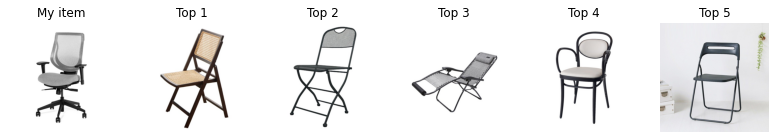

In [10]:
plt.figure(figsize = (16,9))
    
plt.subplot(1,7,1)
image = Image.open('/content/drive/MyDrive/Colab Notebooks/datas/chair.jpg')
plt.imshow(image)
plt.title('My item')
plt.axis('off')

for i in range(5):
    url = cosine_df.loc[i].image_url
    image = Image.open(requests.get(url, stream=True).raw)
    plt.subplot(1,7,i+2)
    plt.imshow(image)
    plt.title('Top {}'.format(i+1))
    plt.axis('off')

### Euclidean Distance

In [11]:
def euclid_dist(A, B):

    return np.linalg.norm(A-B)

euclid_dist_df = []

for idx in feature_vectors_df.index:
    vect = [float(num) for num in feature_vectors_df.iloc[idx]['feature_vectors']]
    euclid_dist_df.append(euclid_dist(target_image, vect))

euclid_dist_df = np.array(euclid_dist_df)
euclid_dist_df

array([1167.91393511, 1380.58406478, 2265.58310315, ..., 1218.28055605,
       1890.94420393, 1798.62805003])

In [12]:
euclid_df = feature_vectors_df.copy()
euclid_df['weight'] = euclid_dist_df.dot(weight)
euclid_df.sort_values('weight', inplace=True)
euclid_df.reset_index(drop=True, inplace=True)

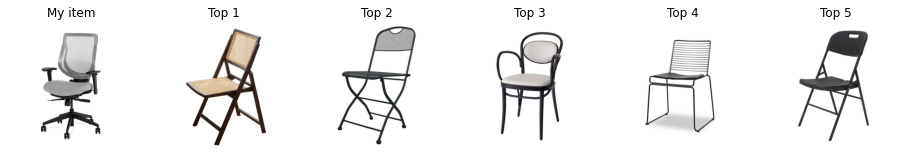

In [13]:
plt.figure(figsize = (16,9))
    
plt.subplot(1,6,1)
image = Image.open('/content/drive/MyDrive/Colab Notebooks/datas/chair.jpg')
plt.imshow(image)
plt.title('My item')
plt.axis('off')

for i in range(5):
    url = euclid_df.loc[i].image_url
    image = Image.open(requests.get(url, stream=True).raw)
    plt.subplot(1,6,i+2)
    plt.imshow(image)
    plt.title('Top {}'.format(i+1))
    plt.axis('off')

### Manhattan Distance

In [14]:
def manhattan_dist(x, y):
    return sum(abs(a-b) for a,b in zip(x,y))

manhattan_dist_df = []

for idx in feature_vectors_df.index:
    vect = [float(num) for num in feature_vectors_df.iloc[idx]['feature_vectors']]
    manhattan_dist_df.append(manhattan_dist(target_image, vect))

manhattan_dist_df = np.array(manhattan_dist_df)
manhattan_dist_df

array([15192.08075798, 16530.33590668, 25983.20675665, ...,
       14339.46780193, 22411.25105514, 20152.91288219])

In [15]:
manhattan_df = feature_vectors_df.copy()
manhattan_df['weight'] = manhattan_dist_df.dot(weight)
manhattan_df.sort_values('weight', inplace=True)
manhattan_df.reset_index(drop=True, inplace=True)

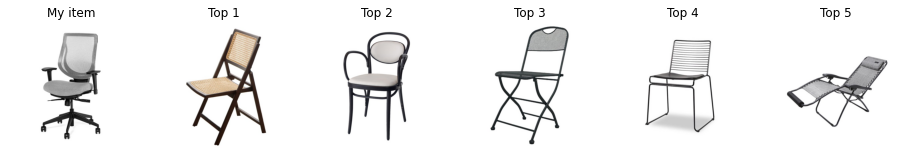

In [16]:
plt.figure(figsize = (16,9))
    
plt.subplot(1,6,1)
image = Image.open('/content/drive/MyDrive/Colab Notebooks/datas/chair.jpg')
plt.imshow(image)
plt.title('My item')
plt.axis('off')

for i in range(5):
    url = manhattan_df.loc[i].image_url
    image = Image.open(requests.get(url, stream=True).raw)
    plt.subplot(1,6,i+2)
    plt.imshow(image)
    plt.title('Top {}'.format(i+1))
    plt.axis('off')